# Pedestrian Depth from Fused Stereo Disparity 
This notebook:

1. Loads stereo sequences (`seq_01`, `seq_02`) and their `labels.txt`.
2. Computes two disparity maps for each frame using StereoSGBM:
   - One tuned for **near/mid pedestrians** (`B_near_close`).
   - One tuned for **far pedestrians** (`B_far_distant`).
3. Fuses both disparity maps into a single **Fused_nearfar** disparity map using a smooth logistic blending
   based on disparity (small disparities → far config dominates, large disparities → near config dominates).
4. For each labeled **Pedestrian** bounding box:
   - Extracts the **central 5% of the bbox area** (keeping the same aspect ratio).
   - Computes the **median disparity** in that crop.
   - Converts the disparity to **depth in meters** using calibration (focal length and baseline).
5. Visualizes the disparity map with:
   - The **full pedestrian bbox** (yellow).
   - The **central 5% crop** actually used for depth estimation (cyan).
   - Text showing **Z_est (estimated depth) vs Z_gt (ground truth)**.
6. Logs all numeric results into `Pedestrian_depth_from_Fused_nearfar.txt` for later analysis.





############################################################
Processing seq_01
############################################################
  seq_01 - Frame 000000.png (frame_idx=0)


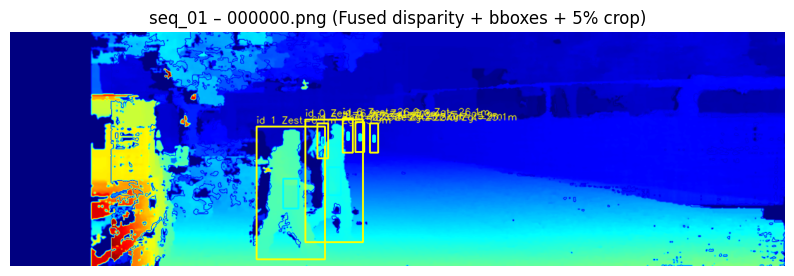

  seq_01 - Frame 000001.png (frame_idx=1)


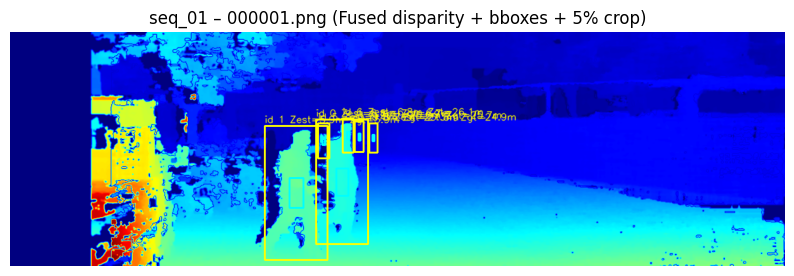

  seq_01 - Frame 000002.png (frame_idx=2)


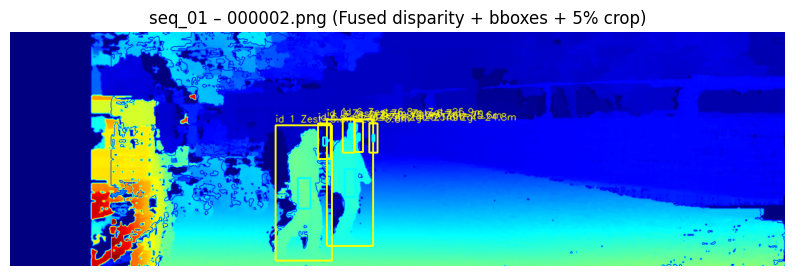

  seq_01 - Frame 000003.png (frame_idx=3)


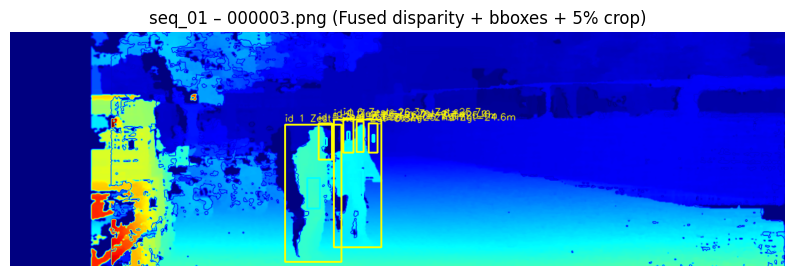

  seq_01 - Frame 000004.png (frame_idx=4)


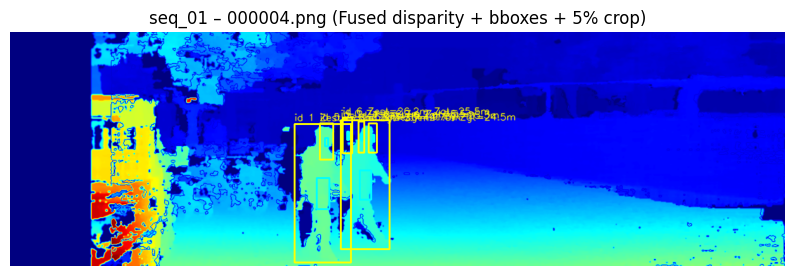

  seq_01 - Frame 000005.png (frame_idx=5)


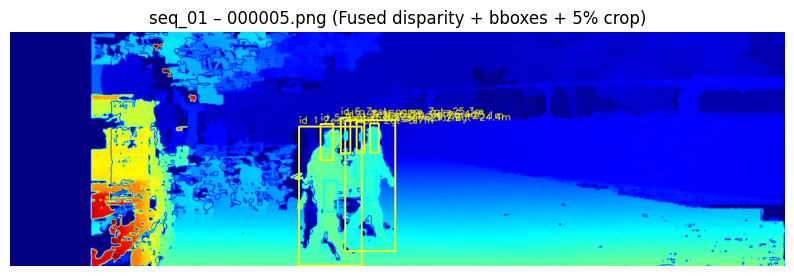

  seq_01 - Frame 000006.png (frame_idx=6)


KeyboardInterrupt: 

In [11]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# =========================================================
# Stereo camera parameters (from calib_cam_to_cam.txt)
# =========================================================
# P_rect_02[0,0] = 7.070493e+02 → fx ≈ 707.0493
# Baseline B ≈ 0.537 m (from T_03.x - T_02.x)
FOCAL_PX   = 707.0493   # focal length in pixels
BASELINE_M = 0.5373     # baseline in meters (approx)

# Use ONLY 5% central area of bbox (same aspect ratio)
AREA_FRACTION = 0.05

# Disparity at which we switch from far→near dominance (px)
D_SPLIT = 10.0
D_BAND  = 2.0   # width of smooth transition band (px)


# =========================================================
# CONFIG: sequences and paths
# =========================================================

sequences = [
    {
        "name": "seq_01",
        "left_base":  Path(r"seq_01/image_02/data"),
        "right_base": Path(r"seq_01/image_03/data"),
        "start": 0,
        "end": 130,
        "step": 1,
        "fmt": "{:06d}.png",
    },
    {
        "name": "seq_02",
        "left_base":  Path(r"seq_02/image_02/data"),
        "right_base": Path(r"seq_02/image_03/data"),
        "start": 0,
        "end": 170,
        "step": 1,
        "fmt": "{:010d}.png",
    },
]

# --- Two specialised SGBM configs for fusion ---
sgbm_configs = [
    {
        "name": "B_near_close",
        "min_disp": 0,
        "num_disp": 160,      # enough range for closer objects
        "block_size": 3,      # finer detail on contours
        "uniquenessRatio": 5,
        "speckleWindowSize": 60,
        "speckleRange": 1,
        "smooth_scale": 0.7,  # slightly lower smoothness → more detail
        "blur_ksize": 3,      # light smoothing
    },
    {
        "name": "B_far_distant",
        "min_disp": 0,
        "num_disp": 128,      # smaller range, focus on small disparities
        "block_size": 7,      # larger window → robust small disparity
        "uniquenessRatio": 3, # more tolerant (far is harder)
        "speckleWindowSize": 120,
        "speckleRange": 2,
        "smooth_scale": 2.0,  # stronger smoothness
        "blur_ksize": 5,      # a bit more smoothing
    },
]


# =========================================================
# Helper: load labels.txt
# =========================================================

def load_picture_labels(label_path: Path):
    labels = []
    with label_path.open("r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            p = line.split()
            if len(p) < 17:
                continue
            obj = {
                "frame":      int(p[0]),
                "track_id":   int(p[1]),
                "type":       p[2],
                "truncation": float(p[3]),
                "occlusion":  int(p[4]),
                "alpha":      float(p[5]),
                "bbox_left":  float(p[6]),
                "bbox_top":   float(p[7]),
                "bbox_right": float(p[8]),
                "bbox_bottom":float(p[9]),
                "h":          float(p[10]),
                "w":          float(p[11]),
                "l":          float(p[12]),
                "X":          float(p[13]),
                "Y":          float(p[14]),
                "Z":          float(p[15]),
                "rotation_y": float(p[16]),
            }
            labels.append(obj)
    return labels


# =========================================================
# Helpers: disparity fusion & depth from bbox
# =========================================================

def fuse_near_far(disp_near, disp_far, d_split=D_SPLIT, band=D_BAND):
    """
    Fuse two disparity maps:
      - disp_near: better for large disparities (near objects)
      - disp_far:  better for small disparities (far objects)

    Uses a logistic blending around d_split.
    Returns: fused disparity map (float32)
    """
    disp_near = disp_near.astype(np.float32)
    disp_far  = disp_far.astype(np.float32)

    H, W = disp_near.shape
    fused = np.zeros((H, W), dtype=np.float32)

    valid_near = disp_near > 0
    valid_far  = disp_far  > 0

    # Case 1: only near valid → use near
    only_near = valid_near & ~valid_far
    fused[only_near] = disp_near[only_near]

    # Case 2: only far valid → use far
    only_far = ~valid_near & valid_far
    fused[only_far] = disp_far[only_far]

    # Case 3: both valid → smooth blend based on disparity (using near disparity)
    both = valid_near & valid_far
    if np.any(both):
        d = disp_near[both]
        # logistic transition from far→near around d_split
        w_near = 1.0 / (1.0 + np.exp(-(d - d_split) / band))
        w_far  = 1.0 - w_near
        fused[both] = w_near * disp_near[both] + w_far * disp_far[both]

    fused[fused < 0] = 0.0
    return fused


def build_sgbm(cfg):
    w = cfg["block_size"]
    smooth_scale = cfg.get("smooth_scale", 1.0)
    P1 = int(8 * 3 * w * w * smooth_scale)
    P2 = int(32 * 3 * w * w * smooth_scale)

    return cv2.StereoSGBM_create(
        minDisparity=cfg["min_disp"],
        numDisparities=cfg["num_disp"],
        blockSize=w,
        P1=P1,
        P2=P2,
        disp12MaxDiff=1,
        uniquenessRatio=cfg["uniquenessRatio"],
        speckleWindowSize=cfg["speckleWindowSize"],
        speckleRange=cfg["speckleRange"],
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY,
    )


def disparity_to_colormap(disp: np.ndarray) -> np.ndarray:
    """
    Convert raw float32 disparity to a colorized image (uint8 BGR).
    """
    disp_valid = disp.copy()
    disp_valid[disp_valid < 0] = 0
    if np.max(disp_valid) <= 0:
        disp_norm = np.zeros_like(disp_valid, dtype=np.uint8)
    else:
        disp_norm = cv2.normalize(disp_valid, None, 0, 255, cv2.NORM_MINMAX)
        disp_norm = np.uint8(disp_norm)
    disp_color = cv2.applyColorMap(disp_norm, cv2.COLORMAP_JET)
    return disp_color


def evaluate_pedestrian_depth_median(disp, labels, frame_idx, area_fraction: float):
    """
    For each Pedestrian in this frame, using the central crop whose area is
    `area_fraction` of the bbox area, compute:

      - median disparity
      - depth Z_est from median disparity
      - Z_gt
      - frac_invalid
      - full bbox and crop bbox coordinates (for visualization)

    Returns list of dicts (one per pedestrian).
    """
    disp = disp.astype(np.float32)
    H, W = disp.shape[:2]
    stats = []

    scale = np.sqrt(area_fraction)  # keep aspect ratio, shrink area

    for o in labels:
        if o["frame"] != frame_idx:
            continue
        if o["type"] != "Pedestrian":
            continue

        x1 = o["bbox_left"]
        y1 = o["bbox_top"]
        x2 = o["bbox_right"]
        y2 = o["bbox_bottom"]

        w_box = x2 - x1
        h_box = y2 - y1
        if w_box <= 1 or h_box <= 1:
            continue

        # Center of bbox
        cx = 0.5 * (x1 + x2)
        cy = 0.5 * (y1 + y2)

        # Scaled half-width / half-height (central area_fraction)
        half_w = 0.5 * w_box * scale
        half_h = 0.5 * h_box * scale

        x1_c = int(round(cx - half_w))
        x2_c = int(round(cx + half_w))
        y1_c = int(round(cy - half_h))
        y2_c = int(round(cy + half_h))

        # Clip to image
        x1_c = np.clip(x1_c, 0, W-1)
        x2_c = np.clip(x2_c, 0, W)
        y1_c = np.clip(y1_c, 0, H-1)
        y2_c = np.clip(y2_c, 0, H)

        if x2_c <= x1_c or y2_c <= y1_c:
            continue

        patch = disp[y1_c:y2_c, x1_c:x2_c]
        if patch.size == 0:
            continue

        valid = patch > 0
        frac_invalid = float((~valid).sum()) / float(patch.size)

        if valid.sum() == 0:
            median_disp = np.nan
        else:
            vals = patch[valid]
            median_disp = float(np.median(vals))

        if median_disp is None or np.isnan(median_disp) or median_disp <= 0:
            Z_est = np.nan
        else:
            Z_est = (FOCAL_PX * BASELINE_M) / median_disp

        stats.append({
            "track_id":     o["track_id"],
            "bbox":         (int(x1), int(y1), int(x2), int(y2)),
            "crop_bbox":    (int(x1_c), int(y1_c), int(x2_c), int(y2_c)),
            "Z_gt":         o["Z"],
            "median_disp":  median_disp,
            "Z_est":        Z_est,
            "frac_invalid": frac_invalid,
        })

    return stats


def draw_bboxes_on_disp(disp_color: np.ndarray, stats):
    """
    Draw full bbox (yellow) and 5% crop bbox (cyan) on the disparity colormap.
    Also overlay id and depth estimate.
    """
    vis = disp_color.copy()

    for s in stats:
        x1, y1, x2, y2 = s["bbox"]
        cx1, cy1, cx2, cy2 = s["crop_bbox"]
        tid = s["track_id"]
        Z_est = s["Z_est"]
        Z_gt  = s["Z_gt"]

        # Full bbox in yellow
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 255), 2)
        # Crop bbox in cyan
        cv2.rectangle(vis, (cx1, cy1), (cx2, cy2), (255, 255, 0), 2)

        txt = f"id {tid} Zest={Z_est:.1f}m Zgt={Z_gt:.1f}m"
        cv2.putText(
            vis,
            txt,
            (x1, max(0, y1 - 5)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 255),
            1,
            lineType=cv2.LINE_AA
        )

    return vis


# =========================================================
# MAIN LOOP: compute fused disparity, show with plt, save depth text
# =========================================================

output_depth_path = Path("Pedestrian_depth_from_Fused_nearfar.txt")
with output_depth_path.open("w") as f_out:

    for seq in sequences:
        print("\n" + "#" * 60)
        print(f"Processing {seq['name']}")
        print("#" * 60)

        left_base  = seq["left_base"]
        right_base = seq["right_base"]
        fmt        = seq["fmt"]

        # labels.txt is in the seq_xx folder
        seq_dir    = left_base.parents[1]
        labels_path = seq_dir / "labels.txt"
        if not labels_path.is_file():
            print(f"  WARNING: no labels.txt found for {seq['name']} at {labels_path}")
            continue

        labels = load_picture_labels(labels_path)

        for frame_idx in range(seq["start"], seq["end"] + 1, seq["step"]):
            fname = fmt.format(frame_idx)

            left_img_path  = left_base  / fname
            right_img_path = right_base / fname

            imgL = cv2.imread(str(left_img_path),  cv2.IMREAD_GRAYSCALE)
            imgR = cv2.imread(str(right_img_path), cv2.IMREAD_GRAYSCALE)

            if imgL is None or imgR is None:
                print(f"  Skipping {seq['name']} - {fname}: could not load one of the images.")
                continue

            print(f"  {seq['name']} - Frame {fname} (frame_idx={frame_idx})")

            # Contrast enhancement
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            imgL_eq = clahe.apply(imgL)
            imgR_eq = clahe.apply(imgR)

            # --- compute raw disparities for near + far configs ---
            disp_maps = {}
            for cfg in sgbm_configs:
                sgbm = build_sgbm(cfg)
                raw_disp = sgbm.compute(imgL_eq, imgR_eq).astype(np.float32) / 16.0

                ksize = cfg.get("blur_ksize", 5)
                if ksize is not None and ksize > 1:
                    raw_disp = cv2.GaussianBlur(raw_disp, (ksize, ksize), 0)

                disp_maps[cfg["name"]] = raw_disp

            # Get near & far maps and fuse
            disp_near = disp_maps["B_near_close"]
            disp_far  = disp_maps["B_far_distant"]
            disp_fused = fuse_near_far(disp_near, disp_far, d_split=D_SPLIT, band=D_BAND)

            # --- make disparity colormap ---
            disp_color = disparity_to_colormap(disp_fused)

            # --- compute depth for pedestrians using median disp in 5% central bbox ---
            stats = evaluate_pedestrian_depth_median(
                disp_fused, labels, frame_idx, AREA_FRACTION
            )

            # --- show visualization with bboxes + crop on disparity map ---
            if stats:
                disp_vis = draw_bboxes_on_disp(disp_color, stats)

                plt.figure(figsize=(10, 5))
                # convert BGR → RGB for matplotlib
                plt.imshow(cv2.cvtColor(disp_vis, cv2.COLOR_BGR2RGB))
                plt.title(f"{seq['name']} – {fname} (Fused disparity + bboxes + 5% crop)")
                plt.axis("off")
                plt.show()

                # Write per-pedestrian info to text file
                f_out.write(f"=== {seq['name']} - Frame {fname} (frame_idx={frame_idx}) ===\n")
                for s in stats:
                    f_out.write(
                        f"  id={s['track_id']}: "
                        f"median_disp={s['median_disp']:.2f}, "
                        f"Z_est={s['Z_est']:.2f}, "
                        f"Z_gt={s['Z_gt']:.2f}, "
                        f"frac_invalid={s['frac_invalid']:.2f}\n"
                    )
                f_out.write("\n")

print(f"\nDone.")
print(f"Depth results saved to: {output_depth_path}")


In [1]:
import os
import time
import cv2
import numpy as np
import math
from scipy.optimize import linear_sum_assignment
from typing import List, Tuple, Any
from pathlib import Path

from kalman_filters import KalmanFilter3D_CA, KalmanFilter3D_CV
import disparity


# =============================
# SINGLE TRACKING LABEL CLASS
# =============================
class TrackingLabel:
    def __init__(self, frame, track_id, obj_type, truncated, occluded, alpha,
                 bbox, dimensions, location, rotation_y, score=None):
        self.frame = int(frame)
        self.track_id = int(track_id)
        self.obj_type = obj_type           # 'Car', 'Pedestrian', 'Cyclist', etc.
        self.truncated = float(truncated)  # 0..1
        self.occluded = int(occluded)      # 0,1,2,3
        self.alpha = float(alpha)          # [-pi, pi]

        self.bbox = np.array(bbox, dtype=float)              # [left, top, right, bottom]
        self.dimensions = np.array(dimensions, dtype=float)  # [h, w, l]
        self.location = np.array(location, dtype=float)      # [x, y, z]
        self.rotation_y = float(rotation_y)                  # [-pi, pi]
        self.score = float(score) if score is not None else None

    def __repr__(self):
        return f"TrackingLabel(frame={self.frame}, track_id={self.track_id}, type={self.obj_type})"


# =============================
# LABEL FILE LOADER CLASS
# =============================
class TrackingLabelLoader:
    def __init__(self, filename):
        self.filename = filename
        self.labels = []

    def load(self):
        with open(self.filename, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 17:  # ignore incomplete lines
                    continue

                frame      = parts[0]
                track_id   = parts[1]
                obj_type   = parts[2]
                truncated  = parts[3]
                occluded   = parts[4]
                alpha      = parts[5]

                bbox       = [parts[6],  parts[7],  parts[8],  parts[9]]
                dimensions = [parts[10], parts[11], parts[12]]
                location   = [parts[13], parts[14], parts[15]]
                rotation_y = parts[16]
                score      = parts[17] if len(parts) > 17 else None

                label = TrackingLabel(frame, track_id, obj_type, truncated, occluded, alpha,
                                      bbox, dimensions, location, rotation_y, score)
                self.labels.append(label)
        return self.labels

    def get_labels_for_frame(self, frame_id):
        """Return all labels for a specific frame."""
        return [label for label in self.labels if label.frame == frame_id]

    def get_labels_for_track(self, track_id):
        """Return all labels for a specific object track."""
        return [label for label in self.labels if label.track_id == track_id]


# =============================
# TRACKED OBJECT CLASS
# =============================
class TrackedObject:
    def __init__(self, track_id, type, color):
        self.track_id = track_id
        self.kf = KalmanFilter3D_CV() if type == "Pedestrian" else KalmanFilter3D_CA()
        self.color = color
        self.last_update = time.time()
        self.initialized = False  # have we ever had a measurement?

    def predict(self, occluded=False):
        """Predict step with occlusion flag."""
        now = time.time()
        dt = now - self.last_update
        if dt <= 0:
            dt = 1e-3
        self.last_update = now
        # kalman_filters.KalmanFilter3D_* predict(dt, occluded=False)
        self.kf.predict(dt, occluded=occluded)

    def update(self, X, Y, Z):
        """Update with a 3D measurement."""
        Z_meas = np.array([[X], [Y], [Z]])
        self.kf.update(Z_meas)
        self.initialized = True

    def get_predicted_position(self):
        return self.kf.x[0, 0], self.kf.x[1, 0], self.kf.x[2, 0]


# =============================
# MULTI-OBJECT TRACKER CLASS
# =============================
class Tracker:
    def __init__(self, colors=None):
        self.tracked_id = None
        # Track ALL types → leave tracked_type = None
        self.tracked_type = None
        self.objects = {}
        self.colors = colors if colors else [(255, 0, 0)]
        self.highest_track_id = 0

    def get_or_create(self, tid, obj_type):
        """Return existing TrackedObject or create a new one."""
        if tid not in self.objects:
            color = self.colors[len(self.objects) % len(self.colors)]
            self.objects[tid] = TrackedObject(tid, obj_type, color)
            if tid > self.highest_track_id:
                self.highest_track_id = tid
        return self.objects[tid]

    def is_tracked(self, tid, type):
        # With tracked_type=None and tracked_id=None, we track everything
        if self.tracked_id is not None and tid == self.tracked_id:
            return True
        if self.tracked_id is None and self.tracked_type is not None and type == self.tracked_type:
            return True
        if self.tracked_id is None and self.tracked_type is None:
            return True
        return False

    def remove_object(self, track_id):
        if track_id in self.objects:
            del self.objects[track_id]


# =============================
# CAMERA
# =============================
class Camera:
    def __init__(self, K_rect):
        self.K = K_rect
        self.fx = K_rect[0, 0]
        self.fy = K_rect[1, 1]
        self.cx = K_rect[0, 2]
        self.cy = K_rect[1, 2]

    def project_point(self, P):
        X, Y, Z = P
        if Z <= 0:
            return None
        u = self.K[0, 0] * X / Z + self.K[0, 2]
        v = self.K[1, 1] * Y / Z + self.K[1, 2]
        return int(u), int(v)

    def backproject_pixel(self, u, v, Z):
        # Z must be in the same scale as K (like meters)
        X = (u - self.cx) * Z / self.fx
        Y = (v - self.cy) * Z / self.fy
        return np.array([X, Y, Z])


# =============================
# OCCLUSION RECTANGLE
# =============================
def is_in_rectangle(uv, rect):
    """Check if a 2D point uv=(u,v) is inside rectangle rect=(x1,y1,x2,y2)."""
    if uv is None:
        return False
    u, v = uv
    x1, y1, x2, y2 = rect
    return x1 <= u <= x2 and y1 <= v <= y2


def associate_detections_to_tracks(detections, tracks, max_distance=1):
    """
    detections: list of (x,y,z)
    tracks: list of predicted (x,y,z) from the Kalman filters

    returns:
        matches: list of (track_idx, detection_idx)
        unmatched_tracks: list of track indices
        unmatched_detections: list of detection indices
    """
    if len(tracks) == 0:
        return [], [], list(range(len(detections)))

    cost_matrix = np.zeros((len(tracks), len(detections)), dtype=np.float32)
    for t, track_pos in enumerate(tracks):
        for d, det_pos in enumerate(detections):
            dist = np.linalg.norm(track_pos - det_pos)
            cost_matrix[t, d] = dist

    track_idx, det_idx = linear_sum_assignment(cost_matrix)

    matches = []
    unmatched_tracks = list(range(len(tracks)))
    unmatched_detections = list(range(len(detections)))

    for t, d in zip(track_idx, det_idx):
        if cost_matrix[t, d] > max_distance:
            continue
        matches.append((t, d))
        unmatched_tracks.remove(t)
        unmatched_detections.remove(d)

    return matches, unmatched_tracks, unmatched_detections


# =============================
# MAIN FUNCTION
# =============================
def main():
    # ---- CONFIG FOR THIS RUN ----
    seq_name = "seq_02"

    image_02_folder = Path(
        r"seq_02/image_02/data"
    )
    image_03_folder = Path(
        r"seq_02/image_03/data"
    )
    label_file = Path(
        r"seq_02/labels.txt"
    )

    # Occlusion rectangle (in left image coordinates)
    occlusion_rect = (660, 100, 910, 350)
    bounding_box = (0, 0, 1224, 370)

    font      = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.7
    fontColor = (255, 255, 255)
    thickness = 3
    lineType  = 2

    # Camera
    camera = Camera(np.array([
        [7.070493e+02, 0.000000e+00, 6.040814e+02, 0.000000e+00],
        [0.000000e+00, 7.070493e+02, 1.805066e+02, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00]
    ]))

    # Load labels
    loader = TrackingLabelLoader(label_file)
    labels = loader.load()

    tracker = Tracker()
    frame_ids = sorted(np.unique([label.frame for label in labels]))

    # ---- BUILD DEPTH DATABASE FROM disparity.py ----
    db = disparity.StereoDepthDatabase(
        sequences_cfg=disparity.sequences,
        sgbm_cfgs=disparity.sgbm_configs,
        focal_px=disparity.FOCAL_PX,
        baseline_m=disparity.BASELINE_M,
        area_fraction=disparity.AREA_FRACTION,
        d_split=disparity.D_SPLIT,
        d_band=disparity.D_BAND,
    )

    print("Computing fused disparity maps...")
    db.compute_all_disparities()
    print("Done computing disparities.")

    # ---- OPEN LOG FILE FOR EVALUATION ----
    log_path = "tracking_depth_with_occlusion_kalman_seq02.txt"
    with open(log_path, "w") as log_f:
        log_f.write(
            "seq frame track_id type bbox "
            "X_true Y_true Z_true "
            "X_meas Y_meas Z_meas "
            "X_est Y_est Z_est "
            "occluded\n"
        )

        # ---- MAIN LOOP OVER FRAMES ----
        for frame_idx in frame_ids:
            if (seq_name, frame_idx) not in db.disparities:
                print(f"[WARN] no disparity precomputed for {seq_name} frame {frame_idx}")
                continue

            frame_labels = loader.get_labels_for_frame(frame_idx)

            # Left image
            img_02_file = os.path.join(image_02_folder, f"{int(frame_idx):010d}.png")
            frame_02 = cv2.imread(img_02_file)
            if frame_02 is None:
                print("Missing frame:", img_02_file)
                continue

            # Right image (not used directly here but kept for completeness)
            img_03_file = os.path.join(image_03_folder, f"{int(frame_idx):010d}.png")
            frame_03 = cv2.imread(img_03_file)
            if frame_03 is None:
                print("Missing frame:", img_03_file)
                continue

            # Draw occlusion rectangle
            cv2.rectangle(frame_02,
                          (occlusion_rect[0], occlusion_rect[1]),
                          (occlusion_rect[2], occlusion_rect[3]),
                          (0, 255, 255), 2)

            for label in frame_labels:
                # Track ALL object types, no filter here

                # Get / create Kalman track
                obj = tracker.get_or_create(label.track_id, label.obj_type)

                # bbox center in image coordinates
                x1, y1, x2, y2 = label.bbox
                center_u = 0.5 * (x1 + x2)
                center_v = 0.5 * (y1 + y2)
                inside_occ = is_in_rectangle((center_u, center_v), occlusion_rect)

                # ----- STEP 1: measurement from disparity (if visible) -----
                meas_xyz = (float("nan"), float("nan"), float("nan"))
                have_measurement = False

                if not inside_occ:
                    res = db.get_depth_for_bbox(
                        seq_name=seq_name,
                        frame_idx=frame_idx,
                        bbox=label.bbox,
                    )
                    if res is not None and not math.isnan(res["Z_est"]):
                        u = res["center_xy"][0]
                        v = res["center_xy"][1]
                        Z_est = res["Z_est"]
                        P3D = camera.backproject_pixel(u, v, Z_est)
                        meas_xyz = (P3D[0], P3D[1], P3D[2])
                        have_measurement = True
                    else:
                        # no valid depth for some reason
                        pass
                # else: inside_occ -> we deliberately ignore disparity, predict only

                # ----- STEP 2: Kalman predict + update -----
                if have_measurement:
                    # visible: normal predict + update
                    obj.predict(occluded=False)
                    obj.update(*meas_xyz)
                else:
                    # occluded or no depth: predict only, with occlusion flag
                    obj.predict(occluded=True)

                X_est, Y_est, Z_est = obj.get_predicted_position()

                # ----- STEP 3: logging & drawing -----
                X_true, Y_true, Z_true = label.location

                bbox_int = tuple(label.bbox.astype(int))
                log_f.write(
                    f"{seq_name} {frame_idx:3d} {label.track_id:3d} {label.obj_type:10s} "
                    f"{bbox_int} "
                    f"{X_true:7.3f} {Y_true:7.3f} {Z_true:7.3f} "
                    f"{meas_xyz[0]:7.3f} {meas_xyz[1]:7.3f} {meas_xyz[2]:7.3f} "
                    f"{X_est:7.3f} {Y_est:7.3f} {Z_est:7.3f} "
                    f"{int(inside_occ)}\n"
                )

                # Console debug
                print(f"[{seq_name}] frame={frame_idx:3d} id={label.track_id:3d} type={label.obj_type}")
                print(f"  bbox = {label.bbox}")
                print(f"  True XYZ       = ({X_true:.2f}, {Y_true:.2f}, {Z_true:.2f})")
                print(f"  Measured XYZ   = ({meas_xyz[0]:.2f}, {meas_xyz[1]:.2f}, {meas_xyz[2]:.2f})")
                print(f"  Kalman XYZ     = ({X_est:.2f}, {Y_est:.2f}, {Z_est:.2f})")
                print(f"  inside_occ     = {inside_occ}\n")

                # Real (ground-truth) circle
                real_uv = camera.project_point(label.location)
                if real_uv is not None and tracker.is_tracked(label.track_id, label.obj_type):
                    color = (0, 255, 0) if not inside_occ else (0, 128, 0)
                    cv2.circle(frame_02, real_uv, 4, color, -1)
                    cv2.putText(frame_02, str(label.track_id), real_uv,
                                font, fontScale, fontColor, thickness, lineType)

                # Estimated 2D position from Kalman
                est_uv = camera.project_point((X_est, Y_est, Z_est))
                if est_uv is not None and tracker.is_tracked(label.track_id, label.obj_type):
                    color = (0, 0, 255) if not inside_occ else (0, 0, 128)
                    cv2.circle(frame_02, est_uv, 4, color, -1)

            cv2.putText(frame_02, str(frame_idx), (1000, 20),
                        font, fontScale, fontColor, thickness, lineType)

            cv2.imshow("Tracking with occlusion-aware Kalman", frame_02)
            if cv2.waitKey(1) == 27:
                break
            time.sleep(0.05)

    cv2.destroyAllWindows()
    print(f"\nDepth + Kalman log (with occlusion) saved to: {log_path}")


if __name__ == "__main__":
    main()


Computing fused disparity maps...
Done computing disparities.
[seq_02] frame=  0 id=  0 type=Car
  bbox = [1096.141118  185.415106 1223.        236.828782]
  True XYZ       = (19.26, 1.78, 24.51)
  Measured XYZ   = (19.89, 1.10, 25.31)
  Kalman XYZ     = (19.87, 1.09, 25.29)
  inside_occ     = False

[seq_02] frame=  0 id=  1 type=Car
  bbox = [1031.968582  183.785008 1157.636703  232.560471]
  True XYZ       = (16.29, 1.60, 23.74)
  Measured XYZ   = (16.75, 0.94, 24.14)
  Kalman XYZ     = (16.74, 0.94, 24.12)
  inside_occ     = False

[seq_02] frame=  0 id=  2 type=Car
  bbox = [ 952.605364  181.930859 1068.611605  234.494197]
  True XYZ       = (13.74, 1.69, 24.23)
  Measured XYZ   = (13.63, 0.93, 23.70)
  Kalman XYZ     = (13.61, 0.93, 23.67)
  inside_occ     = False

[seq_02] frame=  0 id=  3 type=Car
  bbox = [602.556774 172.407984 636.777103 202.727588]
  True XYZ       = (0.72, 1.09, 36.84)
  Measured XYZ   = (nan, nan, nan)
  Kalman XYZ     = (0.00, 0.00, 0.00)
  inside_occ    

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/zsombor/miniconda3/envs/pfas/lib/python3.10/site-packages/cv2/qt/plugins"


[seq_02] frame=  2 id=  0 type=Car
  bbox = [1096.113377  185.391934 1223.        236.803249]
  True XYZ       = (19.26, 1.77, 24.51)
  Measured XYZ   = (19.89, 1.10, 25.32)
  Kalman XYZ     = (19.89, 1.10, 25.31)
  inside_occ     = False

[seq_02] frame=  2 id=  1 type=Car
  bbox = [1031.976706  183.787205 1157.625853  232.562442]
  True XYZ       = (16.29, 1.60, 23.74)
  Measured XYZ   = (16.61, 0.94, 23.93)
  Kalman XYZ     = (16.58, 0.94, 23.90)
  inside_occ     = False

[seq_02] frame=  2 id=  2 type=Car
  bbox = [ 952.609817  181.927569 1068.613933  234.490262]
  True XYZ       = (13.74, 1.69, 24.23)
  Measured XYZ   = (13.61, 0.93, 23.66)
  Kalman XYZ     = (13.61, 0.93, 23.67)
  inside_occ     = False

[seq_02] frame=  2 id=  3 type=Car
  bbox = [602.55594  172.411382 636.774063 202.731062]
  True XYZ       = (0.72, 1.09, 36.84)
  Measured XYZ   = (0.21, 0.10, 9.75)
  Kalman XYZ     = (0.21, 0.10, 9.75)
  inside_occ     = False

[seq_02] frame=  2 id=  4 type=Cyclist
  bbox = [